## Import Library

In [119]:
import pandas as pd
import re
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [120]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## EDA

In [121]:
df = pd.read_csv('Ganjar Pranowo.csv')
df.head()

,Unnamed: 0,Date,Created,User ID,Followers,Following,Tweet Count,TweetLocation,Text,label
0,0,2023-04-16 09:04:01+00:00,2016-05-28 16:50:39+00:00,7.370000e+17,2358,3001,13665,Indonesia,"ganjar is getting more and more support, now s...",Positive
1,1,2023-04-16 08:31:02+00:00,2023-03-31 05:48:36+00:00,1.640000e+18,374,599,621,No Place to KADRUN,ojoo lali yooo who is smart chooses pranowo's ...,Positive
2,2,2023-04-16 08:00:00+00:00,2023-03-31 05:48:36+00:00,1.640000e+18,374,599,621,No Place to KADRUN,smart people support and reward pranowo well,Positive
3,3,2023-04-16 07:56:29+00:00,2022-06-27 14:13:32+00:00,1.540000e+18,11,78,737,NaN,we believe that pranowo's reward is a gift fro...,Positive
4,4,2023-04-16 07:54:14+00:00,2023-03-31 05:48:36+00:00,1.640000e+18,374,599,621,No Place to KADRUN,intelligent people support and reward pranowo ...,Positive


In [122]:
df.shape

(10000, 10)

In [123]:
df = df[['Text', 'label']]
df.head()

,Text,label
0,"ganjar is getting more and more support, now s...",Positive
1,ojoo lali yooo who is smart chooses pranowo's ...,Positive
2,smart people support and reward pranowo well,Positive
3,we believe that pranowo's reward is a gift fro...,Positive
4,intelligent people support and reward pranowo ...,Positive


In [124]:
df.isnull().sum()

,0
Text,115
label,0


In [125]:
df = df.dropna()
df.shape

(9885, 2)

## Cleaning

In [126]:
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'https?://\S+', '', text)
  test = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'[^A-Za-z0-9 ]', '', text)
  text = re.sub(r'\s+', ' ', text)

  return text

In [127]:
df['Text'] = df['Text'].apply(clean_twitter_text)
df['Text'] = df['Text'].str.lower()
df

,Text,label
0,ganjar is getting more and more support now su...,Positive
1,ojoo lali yooo who is smart chooses pranowos r...,Positive
2,smart people support and reward pranowo well,Positive
3,we believe that pranowos reward is a gift from...,Positive
4,intelligent people support and reward pranowo ...,Positive
...,...,...
9995,rt ganjaristdltras ganjarist deltras east java...,Positive
9996,meaning reward pranowo the president,Positive
9997,more and more people are ready to support ganj...,Positive
9998,rt ganjaristdltras ganjarist deltras east java...,Positive


## Tokenisasi

In [128]:
regexp = RegexpTokenizer(r'\w+')
df['Text_token'] = df['Text'].apply(lambda x: regexp.tokenize(str(x)))
df.head()

,Text,label,Text_token
0,ganjar is getting more and more support now su...,Positive,"[ganjar, is, getting, more, and, more, support..."
1,ojoo lali yooo who is smart chooses pranowos r...,Positive,"[ojoo, lali, yooo, who, is, smart, chooses, pr..."
2,smart people support and reward pranowo well,Positive,"[smart, people, support, and, reward, pranowo,..."
3,we believe that pranowos reward is a gift from...,Positive,"[we, believe, that, pranowos, reward, is, a, g..."
4,intelligent people support and reward pranowo ...,Positive,"[intelligent, people, support, and, reward, pr..."


## Lematisasi

In [129]:
lemmatizer = WordNetLemmatizer()

In [130]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [131]:
def lemmatize_tokens(tokens):
    tagged_tokens = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged_tokens
    ]
    return lemmatized

In [132]:
df['Text_token'] = df['Text_token'].apply(lemmatize_tokens)

## Stopword

In [133]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
stopwords_gwehj = ['mr', 'will', 'come', 'make', 'know', 'want', 'really',
                   'must', 'great', 'time', 'still', 'top', 'two', 'one', 'goodness', 'hopefully', 'god', 'blessing', 'thank']
stopwords.extend(stopwords_gwehj)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
df.loc[:, 'Text_token'] = df.loc[:, 'Text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head()

,Text,label,Text_token
0,ganjar is getting more and more support now su...,Positive,"[ganjar, get, support, support, city, batu, ma..."
1,ojoo lali yooo who is smart chooses pranowos r...,Positive,"[ojoo, lali, yooo, smart, chooses, pranowos, r..."
2,smart people support and reward pranowo well,Positive,"[smart, people, support, reward, pranowo, well]"
3,we believe that pranowos reward is a gift from...,Positive,"[believe, pranowos, reward, gift, allah, almig..."
4,intelligent people support and reward pranowo ...,Positive,"[intelligent, people, support, reward, pranowo..."


## Word Cloud

In [135]:
df['Text_string'] = df['Text_token'].apply(lambda x: ' '.join([item for item in x]))
df.head()

,Text,label,Text_token,Text_string
0,ganjar is getting more and more support now su...,Positive,"[ganjar, get, support, support, city, batu, ma...",ganjar get support support city batu malang ea...
1,ojoo lali yooo who is smart chooses pranowos r...,Positive,"[ojoo, lali, yooo, smart, chooses, pranowos, r...",ojoo lali yooo smart chooses pranowos reward
2,smart people support and reward pranowo well,Positive,"[smart, people, support, reward, pranowo, well]",smart people support reward pranowo well
3,we believe that pranowos reward is a gift from...,Positive,"[believe, pranowos, reward, gift, allah, almig...",believe pranowos reward gift allah almighty in...
4,intelligent people support and reward pranowo ...,Positive,"[intelligent, people, support, reward, pranowo...",intelligent people support reward pranowo well


In [136]:
df['Text_string'] = df['Text_string'].astype('str')
df['Text_string'] = df['Text_string'].astype(pd.StringDtype())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9885 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         9885 non-null   object
 1   label        9885 non-null   object
 2   Text_token   9885 non-null   object
 3   Text_string  9885 non-null   string
dtypes: object(3), string(1)
memory usage: 386.1+ KB


Positive Sentiment

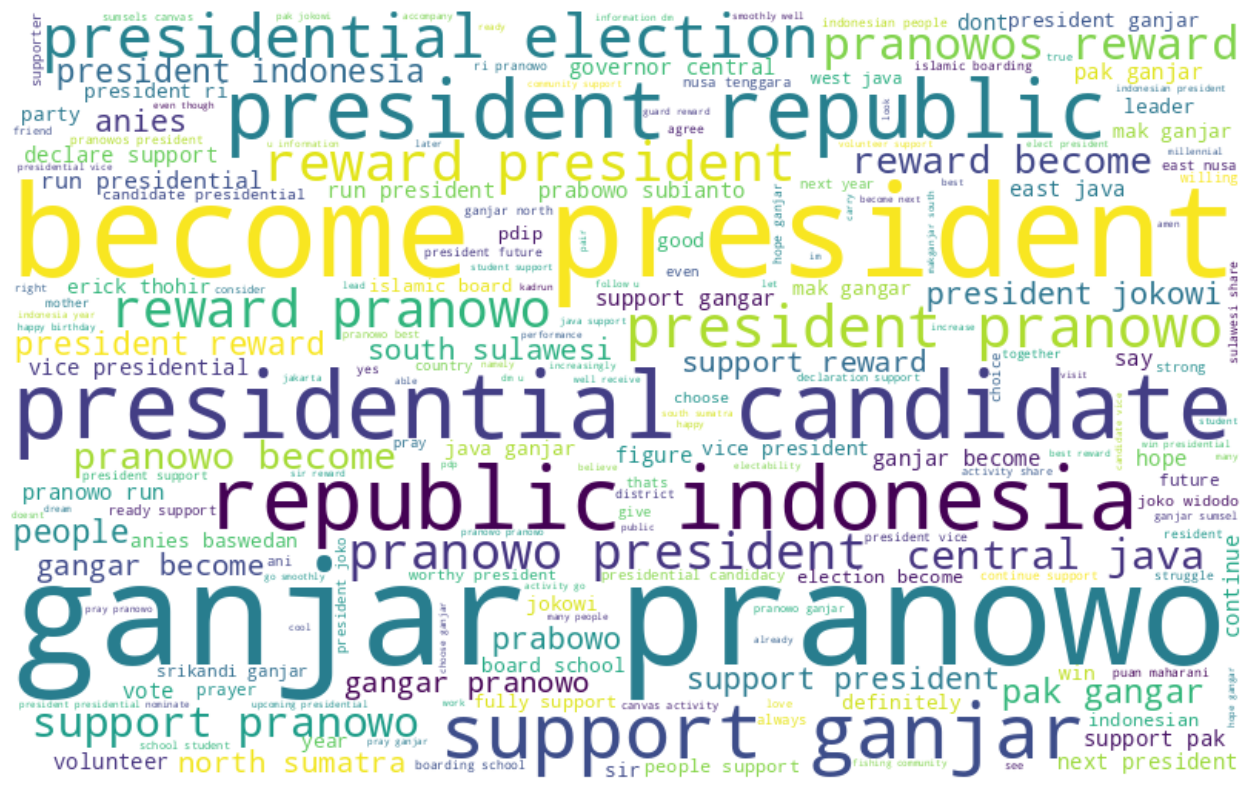

In [137]:
df_p = df[df['label'] == "Positive"]
all_words_lem = ' '.join([word for word in df_p['Text_string']])

from wordcloud import WordCloud
wordcloud = WordCloud(
    background_color='white',
    width = 800,
    height = 500,
    random_state = 21,
    max_font_size = 130
).generate(all_words_lem)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off');

Positive Sentiment

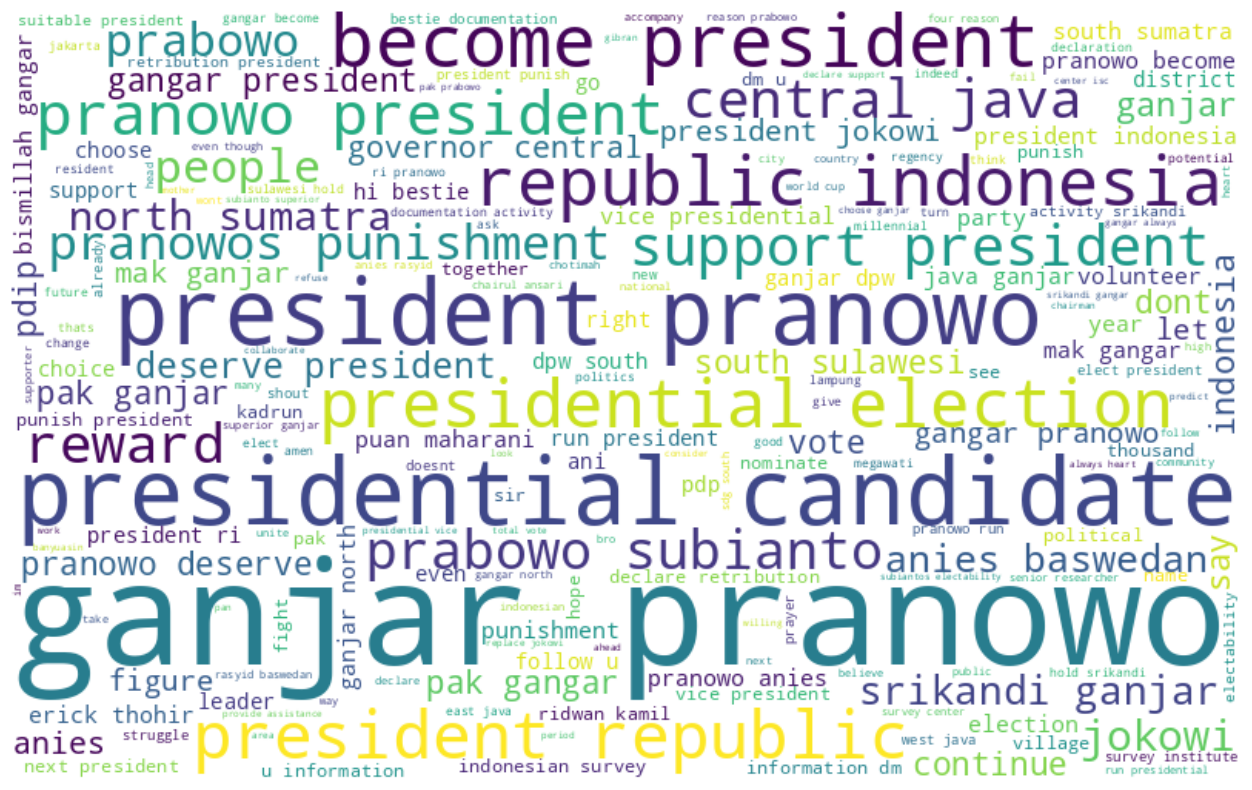

In [138]:
df_p = df[df['label'] == "Negative"]
all_words_lem = ' '.join([word for word in df_p['Text_string']])

from wordcloud import WordCloud
wordcloud = WordCloud(
    background_color='white',
    width = 800,
    height = 500,
    random_state = 21,
    max_font_size = 130
).generate(all_words_lem)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off');

## Modelling

In [139]:
df['label'] = df['label'].apply(lambda x: 1 if x == 'Positive' else 0)
df.head()

,Text,label,Text_token,Text_string
0,ganjar is getting more and more support now su...,1,"[ganjar, get, support, support, city, batu, ma...",ganjar get support support city batu malang ea...
1,ojoo lali yooo who is smart chooses pranowos r...,1,"[ojoo, lali, yooo, smart, chooses, pranowos, r...",ojoo lali yooo smart chooses pranowos reward
2,smart people support and reward pranowo well,1,"[smart, people, support, reward, pranowo, well]",smart people support reward pranowo well
3,we believe that pranowos reward is a gift from...,1,"[believe, pranowos, reward, gift, allah, almig...",believe pranowos reward gift allah almighty in...
4,intelligent people support and reward pranowo ...,1,"[intelligent, people, support, reward, pranowo...",intelligent people support reward pranowo well


In [140]:
X = df['Text_string']
y = df['label']
tfid = TfidfVectorizer()
X_final =  tfid.fit_transform(X)

In [141]:
x_train , x_test , y_train , y_test = train_test_split(X_final , y, test_size = 0.2, random_state = 42)

In [142]:
nb = MultinomialNB()
nb.fit(x_train,y_train)
nb_prediction =  nb.predict(x_test)

## Evaluasi

akurasi =  0.8093070308548306
[[  42  374]
 [   3 1558]]
              precision    recall  f1-score   support

           0       0.93      0.10      0.18       416
           1       0.81      1.00      0.89      1561

    accuracy                           0.81      1977
   macro avg       0.87      0.55      0.54      1977
weighted avg       0.83      0.81      0.74      1977



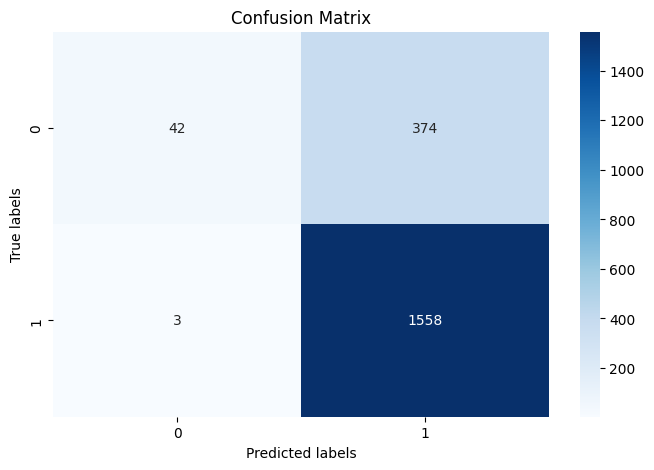

In [143]:
print("akurasi = ", accuracy_score(nb_prediction, y_test))
print(confusion_matrix(y_test, nb_prediction))
print(classification_report(y_test, nb_prediction))

conf_matrix = confusion_matrix(y_test, nb_prediction)


plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()